# ⤵️Import Libraries 

In [1]:
import os
import re
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go

import xlrd
import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats.mstats import winsorize
from scipy.stats.mstats import zscore
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

In [2]:
col_pal = ['#8236CB', 
           '#EB2632']

# 📂Load Data

In [3]:
os.chdir('..')
curr_dir = (os.getcwd()).replace('\\', '/')
file_path = curr_dir + '/Dataset/Prcsd_Healthcare_dataset.xlsx'

In [4]:
drug_df = pd.read_excel(file_path)

In [5]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 65 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   persistency_flag                                                    3424 non-null   object
 1   region                                                              3424 non-null   object
 2   age_bucket                                                          3424 non-null   object
 3   ntm_specialist_flag                                                 3424 non-null   object
 4   ntm_speciality_bucket                                               3424 non-null   object
 5   gluco_record_prior_ntm                                              3424 non-null   object
 6   gluco_record_during_rx                                              3424 non-null   object
 7   dexa_freq_during_rx     

# 🔍Exploratory Data Analysis(EDA)

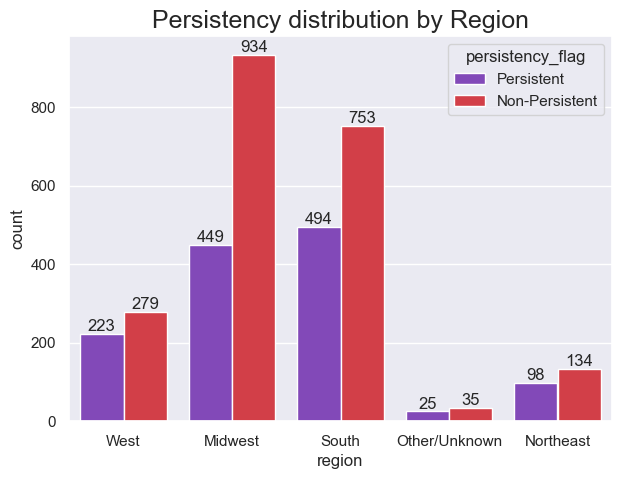

In [6]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='region', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Region', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

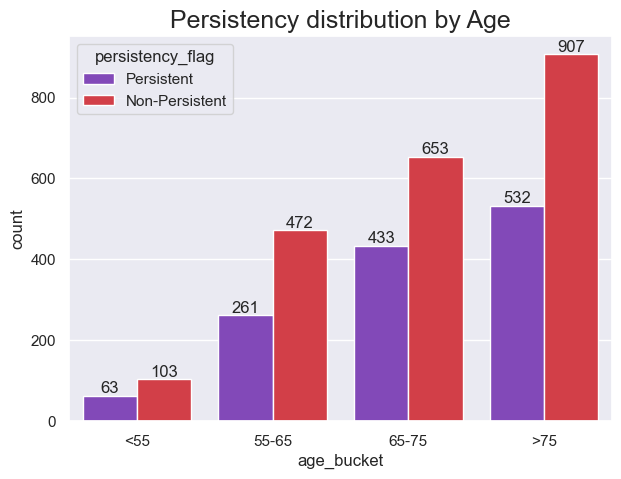

In [40]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='age_bucket', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal, 
                   order=['<55', '55-65', '65-75', '>75'])
ax.set_title('Persistency distribution by Age', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

In [66]:
def create_age_distribution_grid(region_list, 
                                 drug_df, 
                                 col_pal):
    num_regions = len(region_list)
    nrows = num_regions//2
    ncols = num_regions-2
    
    max_count = 0
    
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols, 
                             figsize=(15, 10))

    for i, region in enumerate(region_list):
        row_idx = i // ncols
        col_idx = i % ncols
        
        ax = axes[row_idx, col_idx]
        sns.set(rc={'figure.figsize': (7, 5)})
        sns.countplot(x='age_bucket',
                      data=drug_df[drug_df['region'] == region],
                      hue='persistency_flag',
                      palette=col_pal,
                      ax=ax, 
                      order=['<55', '55-65', '65-75', '>75'])
        ax.set_title('Age distribution by {}'.format(region), 
                     fontsize=12, 
                     pad=15)
        for label in ax.containers:
            ax.bar_label(label)
            
        current_max = max(ax.patches, 
                          key=lambda x: x.get_height()).get_height()
        max_count = max(max_count, 
                        current_max)
    
    # Setting same y limits for all the plots in the grid
    for i in range(num_regions):
        row_idx = i // ncols
        col_idx = i % ncols
        ax = axes[row_idx, col_idx]
        ax.set_ylim(0, max_count + 1)
        
    # Removing empty subplots, if any
    for i in range(num_regions, nrows * ncols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

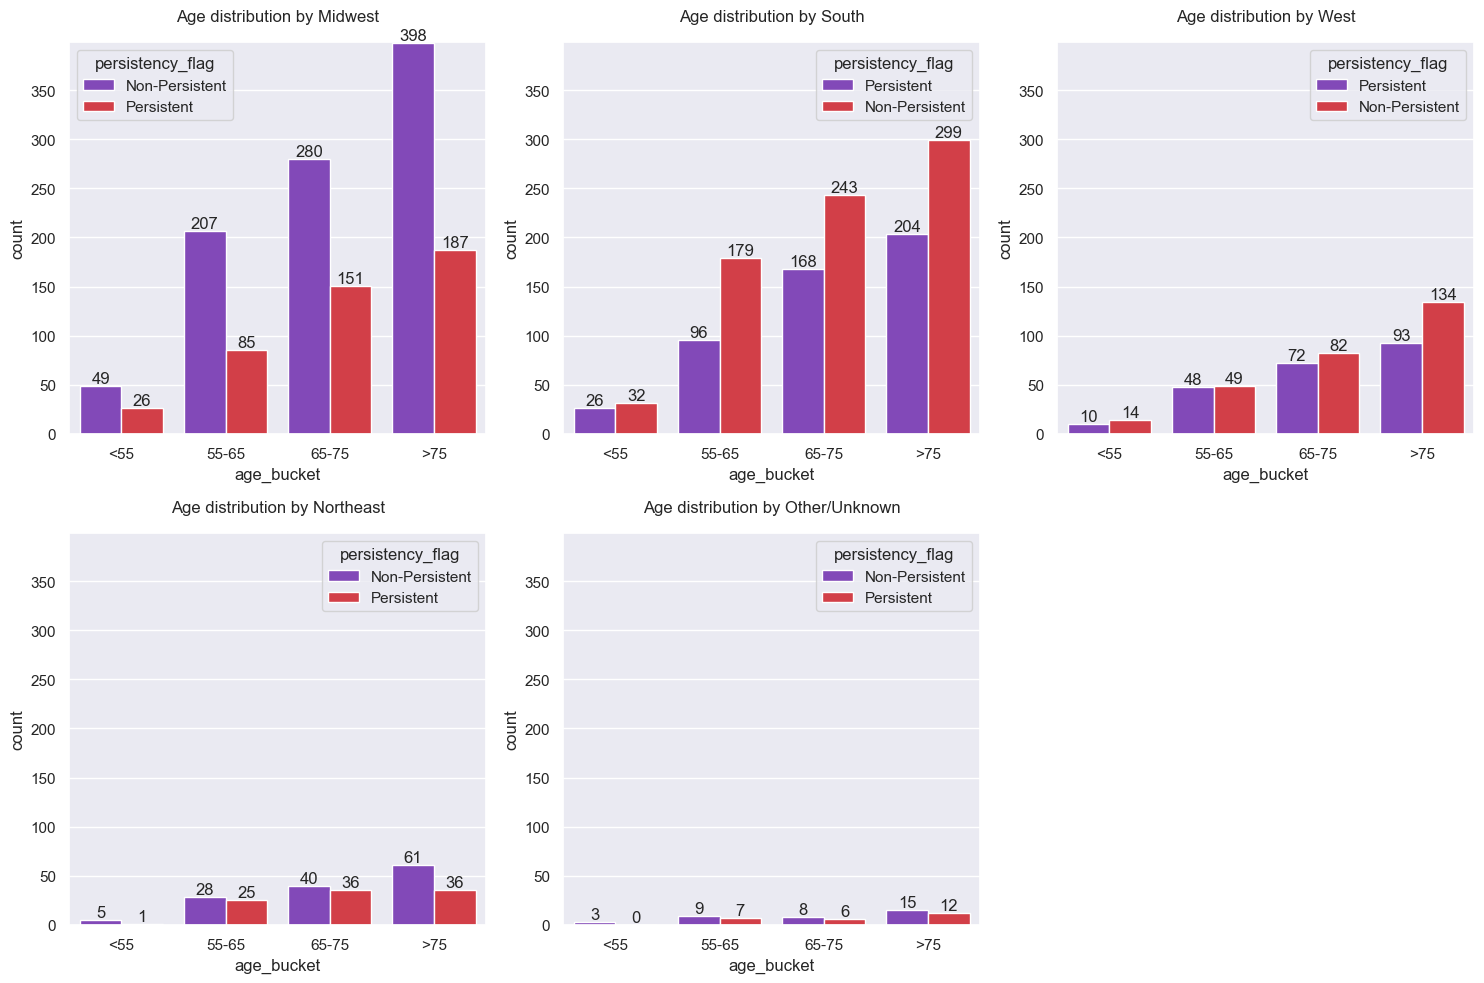

In [67]:
region_list = list(drug_df['region'].value_counts().index)
create_age_distribution_grid(region_list, drug_df, col_pal)

- Based on the distribution by region, we can conclude that majority recordings are from *Midwest* and *South* regions.
- Majority of the patients recorded are above 55 years of age.

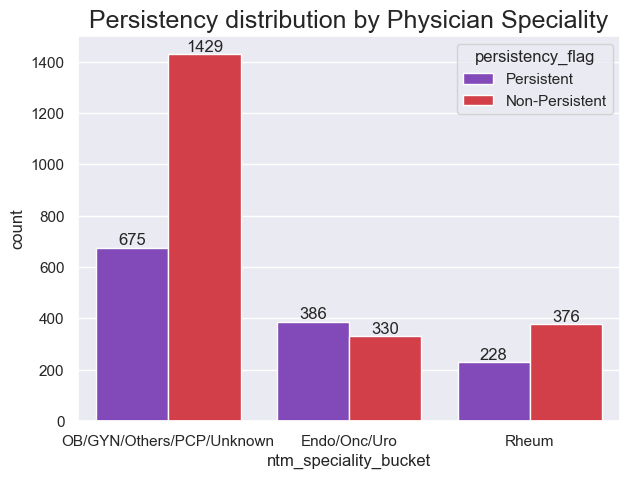

In [94]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ntm_speciality_bucket', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Persistency distribution by Physician Speciality', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

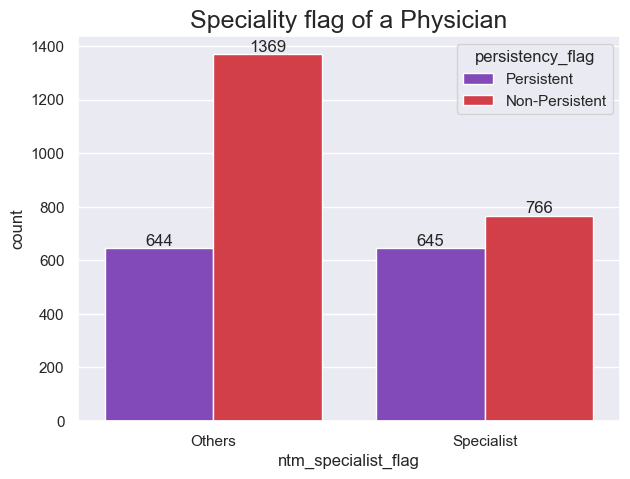

In [9]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ntm_specialist_flag', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Speciality flag of a Physician', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

In [75]:
def create_physpc_distribution_grid(physician_cat, 
                                    drug_df, 
                                    col_pal):
    num_physicians = len(physician_cat)    
    max_count = 0
    
    fig, axes = plt.subplots(nrows=1, 
                             ncols=num_physicians, 
                             figsize=(15, 5))

    for i, physician in enumerate(physician_cat):
        ax = axes[i]
        sns.set(rc={'figure.figsize': (7, 5)})
        sns.countplot(x='ntm_specialist_flag',
                      data=drug_df[drug_df['ntm_speciality_bucket'] == physician],
                      hue='persistency_flag',
                      palette=col_pal,
                      ax=ax)
        ax.set_title('Specialist distribution by {}'.format(physician), 
                     fontsize=12, 
                     pad=15)
        for label in ax.containers:
            ax.bar_label(label)
            
        current_max = max(ax.patches, 
                          key=lambda x: x.get_height()).get_height()
        max_count = max(max_count, 
                        current_max)
    
    # Setting same y limits for all the plots in the grid
    for i in range(num_physicians):
        ax = axes[i]
        ax.set_ylim(0, max_count + 1)

    plt.tight_layout()
    plt.show()

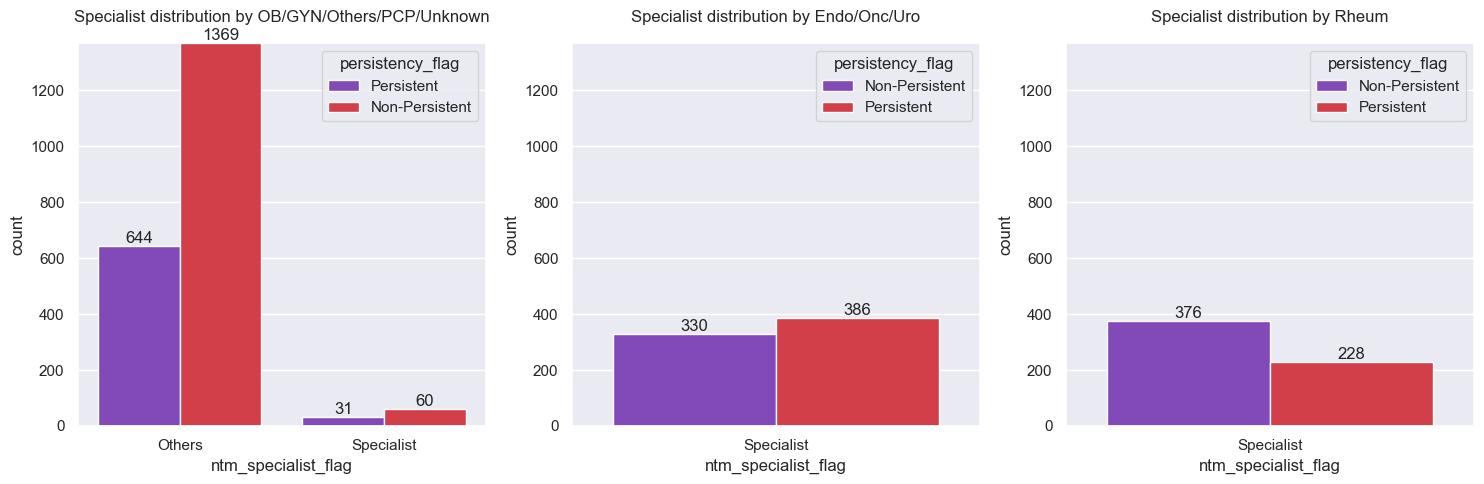

In [76]:
physician_cat = list(drug_df['ntm_speciality_bucket'].value_counts().index)
create_physpc_distribution_grid(physician_cat, drug_df, col_pal)

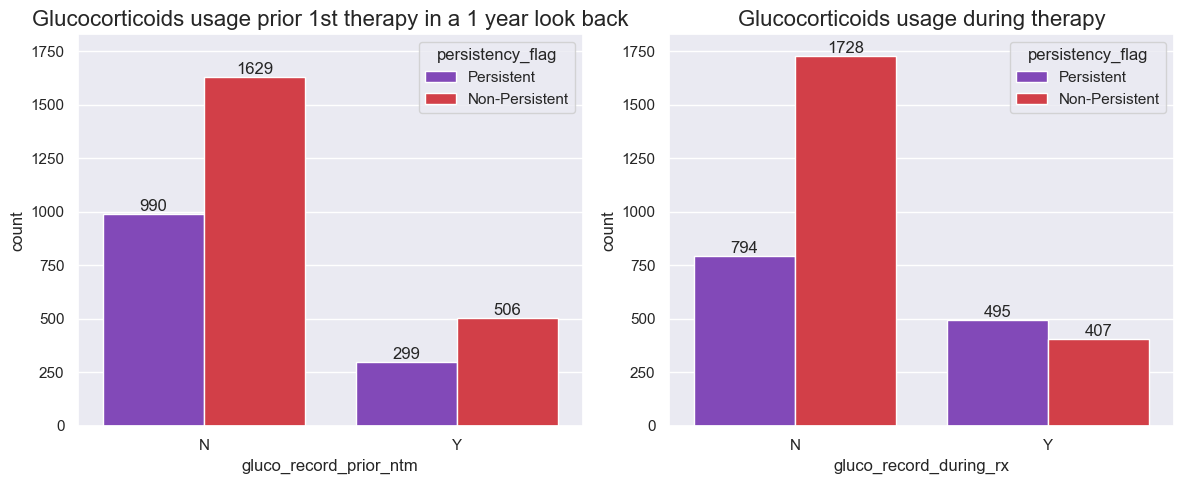

In [115]:
figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

max_count = max(
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_during_rx'] == 'N')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_during_rx'] == 'Y')])),
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_prior_ntm'] == 'N')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_prior_ntm'] == 'Y')]))
)

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='gluco_record_prior_ntm', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax[0].set_title('Glucocorticoids usage prior 1st therapy in a 1 year look back', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.countplot(x='gluco_record_during_rx', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax[1].set_title('Glucocorticoids usage during therapy', 
             fontsize=16)
for label in ax[1].containers:
    ax[1].bar_label(label)

for i in range(2):
    ax[i].set_ylim(0, max_count + 100)

plt.tight_layout()
plt.show()